## Housing Affordability by Sean Mannisto

This notebook:
- Creates the dataset for my Tableau visualization of housing affordability at:
https://public.tableau.com/app/profile/sean.mannisto/viz/HousingPricetoIncomeRatios/Sheet1

- Creates a color and size-coded scatterplot of all US counties and their relative housing affordability

- Calculates a Multiple Linear Regression Model

- Calculates and plots statistics

 Original Datasets:

 - Zillow "Housing Value Index All Homes Time Series Smoothed Seasonally Adjusted"
 https://www.zillow.com/research/data/

 - USDA "Unemployment and median household income for the U.S., States, and counties, 2000-2021" 
 https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/


- US Census API American Community Survey 2021
  - B25103_001E is "Median Real Estate Taxes Paid (Dollars)" 
  - B01003_001E is "Estimate, Total Population"
  

Notes:
- Federal Information Processing Standards (FIPS) code used as county index.
- Some very low population counties have insufficient real estate data, particularly in the western Great Plains
- Known Issue: Tax values above 9999 are all recorded as 10001 in the ACS

Load in libraries

In [674]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pandas.core.reshape.merge import string
import requests
from requests.api import head
import statsmodels.api as sm


In [675]:
!pip install colorspacious
from colorspacious import cspace_converter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load Zillow Housing Value Index data, 

In [676]:
# set Zillow Housing Value Index URL
zhvi_url = "https://files.zillowstatic.com/research/public_csvs/zhvi/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1670291347"
# Download and read CSV 
zhvi_raw = pd.read_csv(zhvi_url)
zhvi_raw.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,3101,0,Los Angeles County,county,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",6,37,217219.0,...,849467.0,867274.0,882623.0,884311.0,883805.0,870575.0,859871.0,848269.0,846262.0,845596.0
1,139,1,Cook County,county,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",17,31,173902.0,...,301166.0,303308.0,306745.0,309530.0,311511.0,311997.0,312558.0,313027.0,313775.0,312317.0
2,1090,2,Harris County,county,TX,TX,"Houston-The Woodlands-Sugar Land, TX",48,201,115286.0,...,269990.0,275086.0,280076.0,283929.0,286477.0,288032.0,288399.0,289143.0,289720.0,289591.0
3,2402,3,Maricopa County,county,AZ,AZ,"Phoenix-Mesa-Chandler, AZ",4,13,142739.0,...,457069.0,468583.0,477443.0,483784.0,481374.0,474787.0,464870.0,459841.0,454753.0,451699.0
4,2841,4,San Diego County,county,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",6,73,225274.0,...,887685.0,906908.0,920069.0,919535.0,908231.0,897158.0,890169.0,885101.0,880975.0,874095.0


In [677]:
#print(zhvi_raw.sample(n=6))

Set date name, reformat FIPS, fill Metro Area NaN with blank strings

In [678]:
zhvi=zhvi_raw.copy()

# Set most recent date to "recent_ZHVI" column
zhvi["recent_ZHVI"] = zhvi.iloc[:,-1]

# Convert State and Municipal FIPS into single FIPS code. Format as 5 digits
zhvi["FIPS"] = zhvi["StateCodeFIPS"]*1000 + zhvi["MunicipalCodeFIPS"]
zhvi["FIPS"] = zhvi["FIPS"].apply(lambda x: '{0:0>5}'.format(x))

# Fill empty metro areas with blank strings
zhvi[['Metro']] = zhvi[['Metro']].fillna('')

zhvi.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2000-01-31,...,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,recent_ZHVI,FIPS
0,3101,0,Los Angeles County,county,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",6,37,217219.0,...,882623.0,884311.0,883805.0,870575.0,859871.0,848269.0,846262.0,845596.0,845596.0,06037
1,139,1,Cook County,county,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",17,31,173902.0,...,306745.0,309530.0,311511.0,311997.0,312558.0,313027.0,313775.0,312317.0,312317.0,17031
2,1090,2,Harris County,county,TX,TX,"Houston-The Woodlands-Sugar Land, TX",48,201,115286.0,...,280076.0,283929.0,286477.0,288032.0,288399.0,289143.0,289720.0,289591.0,289591.0,48201
3,2402,3,Maricopa County,county,AZ,AZ,"Phoenix-Mesa-Chandler, AZ",4,13,142739.0,...,477443.0,483784.0,481374.0,474787.0,464870.0,459841.0,454753.0,451699.0,451699.0,04013
4,2841,4,San Diego County,county,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",6,73,225274.0,...,920069.0,919535.0,908231.0,897158.0,890169.0,885101.0,880975.0,874095.0,874095.0,06073


Define Function to Plot County Housing Price over Time
Parameters:
  - Number of counties to plot
  - Number of columns wide
  - True or False: Top N Counties or Random Sample 

In [679]:
# Define the function to plot a selected number of counties
# 
# Note: Horizontal Scale changes to fully fit the available date range. 
#       Not all counties have the full time frame of data. 
#       Vertical scale is based the max price between the chosen counties
#       Scale can change between iterations of the plot function



def plot_ZHVI_county(num_counties:int, plot_width:int, top=True):
  
  if top == True:
# Get the top populated counties
    sel_coun = zhvi[zhvi["SizeRank"] <= num_counties] 
  else:
# Get a random sample of counties
    sel_coun = zhvi.sample(n=10)

# filter only the columns with valid date names
  sel_coun = sel_coun.filter(regex='\d{4}-\d{2}-\d{2}', axis=1)

# set the maximum value of y-axis
  ymax = np.nanmax(sel_coun.values)

# Calculate the number of rows for the plot
  plot_height = num_counties // plot_width + (num_counties % plot_width != 0)

# Calculate Figure Height
  fig_height = plot_height*5

# Create a figure with multiple subplots
  fig, axs = plt.subplots(nrows=plot_height, ncols=plot_width, figsize=(20, fig_height),
                       tight_layout=True)

# Plot the housing prices for each county on a separate subplot
  for i, county in enumerate(sel_coun.index[:num_counties]):
      row = i // plot_width
      col = i % plot_width
    # Extract the date values from the columns and use them as the x-axis
      x = [pd.to_datetime(col) for col in sel_coun.columns]
      #x = [pd.date_range(start='2000-01-01', end='2024-12-31')]
      #axs[row, col].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
      y = sel_coun.loc[county]
      
      axs[row, col].plot(x, y)

      # If there is an associated Metro Area, include it in the title 
      if zhvi.loc[county,'Metro'] != '':
        axs[row, col].set_title(zhvi.loc[county,'RegionName']+'\n'+zhvi.loc[county,'Metro'])
      # Otherwise just add the state
      else:
        axs[row, col].set_title(zhvi.loc[county,'RegionName']+", "+zhvi.loc[county,'State'])
      axs[row, col].set_ylim(0, ymax)
    
  plt.show()

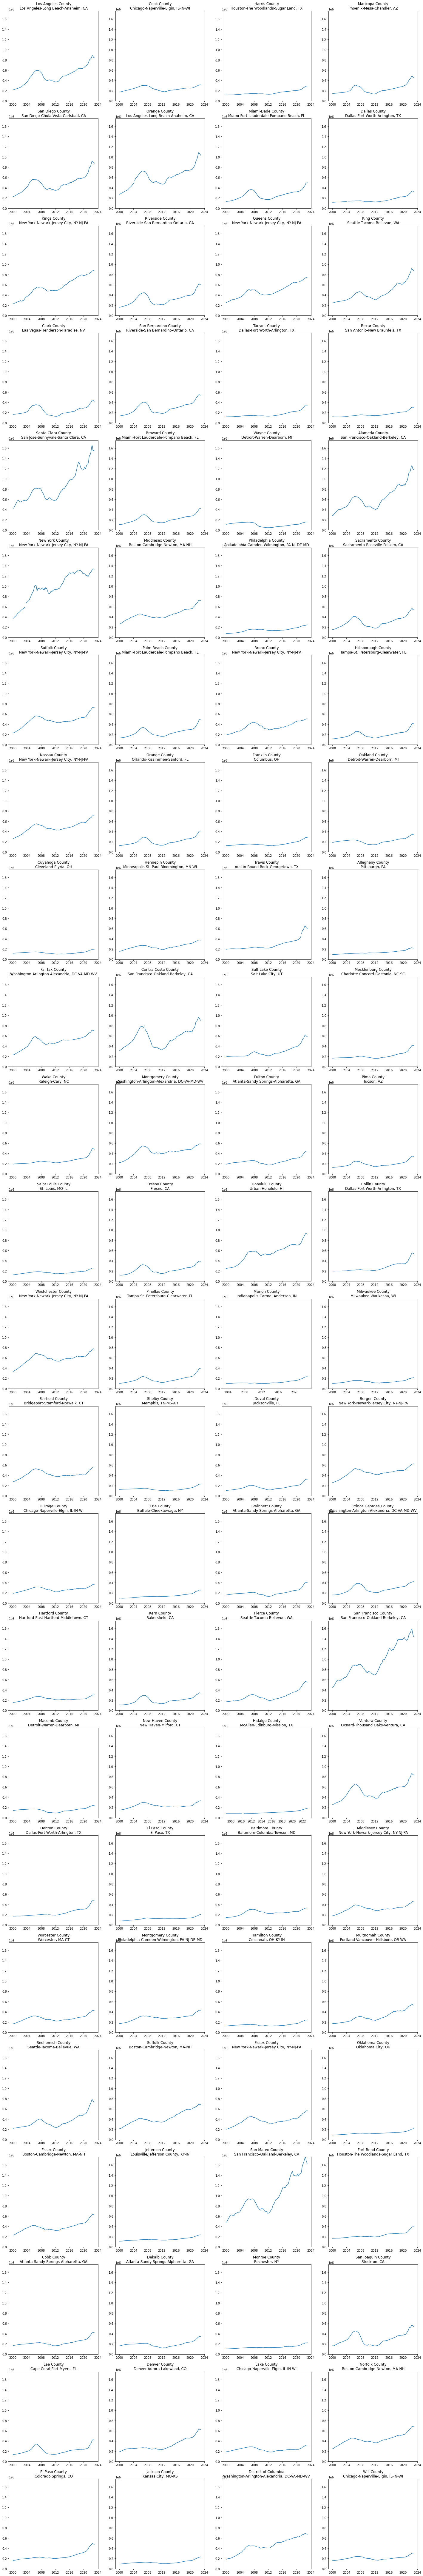

<Figure size 720x432 with 0 Axes>

In [798]:
# Plot top 24 most populated counties
# Select 24 counties total
# 4 plots wide
# Flag for Top N counties vs Random counties set to Top
plot_ZHVI_county(num_counties=96, plot_width=4, top=True)

# Export as an image
plt.savefig('Sample_County_Price_Time.png')

Set relevant columns to new price dataframe and drop entries with no price data

In [681]:
# Only FIPS code, Name, Most Recent Price 
zhvi2 = zhvi[["FIPS", "RegionName", "recent_ZHVI"]]

# Drop null rows
zhvi2 = zhvi2.dropna(subset=['recent_ZHVI'])

# Preview
zhvi2.head()

,FIPS,RegionName,recent_ZHVI
0,06037,Los Angeles County,845596.0
1,17031,Cook County,312317.0
2,48201,Harris County,289591.0
3,04013,Maricopa County,451699.0
4,06073,San Diego County,874095.0


Download and read in USDA employment and income CSV to dataframe

In [682]:
# set USDA URL
unemp_url = "https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.xlsx?v=7156"

# The first 3 rows are source information, so header index is set to start at row 4.
unemployment = pd.read_excel(unemp_url, "Unemployment Med HH Income", header = 4)


In [683]:
# Shape of the dataframe
print("Dataframe Shape: "+ str(unemployment.shape))
# Preview
unemployment.head()

Dataframe Shape: (3277, 96)


,FIPS_code,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,...,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Civilian_labor_force_2021,Employed_2021,Unemployed_2021,Unemployment_rate_2021,Median_Household_Income_2020,Med_HH_Income_Percent_of_State_Total_2020
0,0,US,United States,NaN,NaN,NaN,142601576.0,136904853.0,5696723.0,3.994853,...,161207103.0,148183367.0,13023736.0,8.078885,161758337.0,153099687.0,8658650.0,5.352831,67340.0,NaN
1,1000,AL,Alabama,NaN,NaN,NaN,2147173.0,2047731.0,99442.0,4.600000,...,2268309.0,2121149.0,147160.0,6.500000,2246993.0,2169721.0,77272.0,3.400000,53958.0,100.000000
2,1001,AL,"Autauga County, AL",2.0,2.0,1.0,21861.0,20971.0,890.0,4.100000,...,26405.0,24985.0,1420.0,5.400000,26341.0,25599.0,742.0,2.800000,67565.0,125.217762
3,1003,AL,"Baldwin County, AL",3.0,2.0,1.0,69979.0,67370.0,2609.0,3.700000,...,98910.0,92751.0,6159.0,6.200000,99427.0,96481.0,2946.0,3.000000,71135.0,131.834019
4,1005,AL,"Barbour County, AL",6.0,6.0,0.0,11449.0,10812.0,637.0,5.600000,...,8680.0,8004.0,676.0,7.800000,8197.0,7728.0,469.0,5.700000,38866.0,72.030097


Clean & reformat USDA data and keep only relevant columns

In [684]:
# Save nationwide stats for later
US_LF = unemployment.iloc[0]["Civilian_labor_force_2021"]
US_MHI = unemployment.iloc[0]["Median_Household_Income_2020"]

# Check the "Rural_urban_continuum_code_2013" column for rows with null values.
unemployment = unemployment.loc[pd.notna(unemployment['Rural_urban_continuum_code_2013'])]

# Format FIPS code to 5 digits using lambda function on a copy
unemployment = unemployment.copy()
unemployment.loc[:, "FIPS_code"]=unemployment.loc[:, "FIPS_code"].apply(lambda x: '{0:0>5}'.format(x))

#Set as new income dataframe with only the relevant columns.
unemployment = unemployment[["FIPS_code", "Area_name", "Civilian_labor_force_2021", "Median_Household_Income_2020", "Rural_urban_continuum_code_2013"]]
unemployment.head()


,FIPS_code,Area_name,Civilian_labor_force_2021,Median_Household_Income_2020,Rural_urban_continuum_code_2013
2,01001,"Autauga County, AL",26341.0,67565.0,2.0
3,01003,"Baldwin County, AL",99427.0,71135.0,3.0
4,01005,"Barbour County, AL",8197.0,38866.0,6.0
5,01007,"Bibb County, AL",8560.0,50907.0,1.0
6,01009,"Blount County, AL",25127.0,55203.0,1.0


Join unemployment and house price dataframes

In [719]:
# Merge on FIPS code columns
merged1 = pd.merge(left=unemployment, right=zhvi2, left_on='FIPS_code', right_on='FIPS')
merged1.head()

,FIPS_code,Area_name,Civilian_labor_force_2021,Median_Household_Income_2020,Rural_urban_continuum_code_2013,FIPS,RegionName,recent_ZHVI
0,01001,"Autauga County, AL",26341.0,67565.0,2.0,01001,Autauga County,247745.0
1,01003,"Baldwin County, AL",99427.0,71135.0,3.0,01003,Baldwin County,378538.0
2,01005,"Barbour County, AL",8197.0,38866.0,6.0,01005,Barbour County,137713.0
3,01007,"Bibb County, AL",8560.0,50907.0,1.0,01007,Bibb County,183821.0
4,01009,"Blount County, AL",25127.0,55203.0,1.0,01009,Blount County,265515.0


Get Census Data

In [720]:
# set my Census API key as a variable
api_key = "f229871d75fd694d4cd998c8f640e953e8b97157"

Define function to get Census API data and return a reformatted dataframe

In [721]:
# data_code is desired Census API code for desired data
# data_name is what you want to call that column
# Returns a Pandas dataframe
def get_acs2021_data(data_code, data_name):

# Concatenate the API endpoint URL
  api_url = "https://api.census.gov/data/2021/acs/acs5?get=NAME," + data_code + "&for=county:*&in=state:*&key=" + api_key

# Send the call/request
  response = requests.get(api_url)

  if response.status_code == 200:
    print("Request successful")
  else:
    print("Error: " + response.status_code)

# Parse the JSON data
  api_data = response.json()

# Convert the JSON data into a pandas DataFrame
  df = pd.DataFrame(api_data)

# Convert 1st row to column headers
  df.columns = df.iloc[0]
  df = df[1:]

# Rename the column
  df.rename(columns={data_code:data_name}, inplace = True)

# Convert State and Municipal FIPS into single FIPS code. Format as 5 digits
  df['FIPS_code'] = df.apply(lambda row: '{0:0>2}'.format(row["state"]) + '{0:0>3}'.format(row["county"]), axis=1)

  return df


In [722]:
# Table B25103: Mortgage Status by Median Real Estate Taxes Paid (Dollars)
# B25103_001E is "Median Real Estate Taxes Paid (Dollars)"
data_code = "B25103_001E"
data_name = "med_tax"
# Call API and set resulting data as tax_df
tax_df = get_acs2021_data(data_code, data_name)
tax_df.head()


Request successful


,NAME,med_tax,state,county,FIPS_code
1,"Autauga County, Alabama",491,01,001,01001
2,"Baldwin County, Alabama",718,01,003,01003
3,"Barbour County, Alabama",338,01,005,01005
4,"Bibb County, Alabama",263,01,007,01007
5,"Blount County, Alabama",416,01,009,01009


In [723]:
# Random sample
print(tax_df.sample(n=10))


0                                  NAME med_tax state county FIPS_code
3176      Gurabo Municipio, Puerto Rico    1319    72    063     72063
2789                  Iron County, Utah    1292    49    021     49021
839                Jackson County, Iowa    1788    19    097     19097
3094          Ozaukee County, Wisconsin    4279    55    089     55089
3126              Crook County, Wyoming    1371    56    011     56011
1883             Tioga County, New York    3358    36    107     36107
1446        Lowndes County, Mississippi     830    28    087     28087
597              Adams County, Illinois    2229    17    001     17001
58            St. Clair County, Alabama     544    01    115     01115
2355  Orangeburg County, South Carolina     612    45    075     45075


In [724]:
# Convert strings to numbers
tax_df["med_tax"] = tax_df["med_tax"].astype(float)

# Replace error -666666666 values with blanks
tax_df["med_tax"] = tax_df["med_tax"].replace(-666666666, np.nan)

In [725]:
# Calculate and print mean tax
mean_tax = tax_df["med_tax"].mean()
print("Mean Tax Value: " + str(mean_tax))

Mean Tax Value: 1682.59225725882


In [726]:
# Replace errors with the mean of all county tax values
tax_df["med_tax"] = tax_df["med_tax"].fillna(mean_tax)

In [727]:
print(tax_df.sample(n=6))

0                                NAME  med_tax state county FIPS_code
2933          Hopewell city, Virginia   1303.0    51    670     51670
2552           Caldwell County, Texas   2505.0    48    055     48055
1153  Pointe Coupee Parish, Louisiana    456.0    22    077     22077
2061            Crawford County, Ohio   1320.0    39    033     39033
168         Poinsett County, Arkansas    476.0    05    111     05111
3018     Marion County, West Virginia    833.0    54    049     54049


In [728]:
# Merge with other table
merged2=pd.merge(left=merged1, right=tax_df, left_on='FIPS_code', right_on='FIPS_code')

In [729]:
# Get the State abbreviation from the last 2 characters of Area_name
merged2['ST_name'] = merged2['Area_name'].str[-2:]

In [730]:
merged2

,FIPS_code,Area_name,Civilian_labor_force_2021,Median_Household_Income_2020,Rural_urban_continuum_code_2013,FIPS,RegionName,recent_ZHVI,NAME,med_tax,state,county,ST_name
0,01001,"Autauga County, AL",26341.0,67565.0,2.0,01001,Autauga County,247745.0,"Autauga County, Alabama",491.0,01,001,AL
1,01003,"Baldwin County, AL",99427.0,71135.0,3.0,01003,Baldwin County,378538.0,"Baldwin County, Alabama",718.0,01,003,AL
2,01005,"Barbour County, AL",8197.0,38866.0,6.0,01005,Barbour County,137713.0,"Barbour County, Alabama",338.0,01,005,AL
3,01007,"Bibb County, AL",8560.0,50907.0,1.0,01007,Bibb County,183821.0,"Bibb County, Alabama",263.0,01,007,AL
4,01009,"Blount County, AL",25127.0,55203.0,1.0,01009,Blount County,265515.0,"Blount County, Alabama",416.0,01,009,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,56037,"Sweetwater County, WY",19449.0,70583.0,5.0,56037,Sweetwater County,310903.0,"Sweetwater County, Wyoming",1329.0,56,037,WY
2836,56039,"Teton County, WY",15886.0,92488.0,7.0,56039,Teton County,1692558.0,"Teton County, Wyoming",4354.0,56,039,WY
2837,56041,"Uinta County, WY",8832.0,71246.0,7.0,56041,Uinta County,288030.0,"Uinta County, Wyoming",1191.0,56,041,WY
2838,56043,"Washakie County, WY",3978.0,58532.0,7.0,56043,Washakie County,242134.0,"Washakie County, Wyoming",1305.0,56,043,WY


Load Census Population Data

In [731]:
# Table B01003: Total Population
# B01003_001E is "Estimate Total"
data_code = "B01003_001E"
data_name = "total_pop"

pop_df = get_acs2021_data(data_code, data_name)
pop_df

Request successful


,NAME,total_pop,state,county,FIPS_code
1,"Autauga County, Alabama",58239,01,001,01001
2,"Baldwin County, Alabama",227131,01,003,01003
3,"Barbour County, Alabama",25259,01,005,01005
4,"Bibb County, Alabama",22412,01,007,01007
5,"Blount County, Alabama",58884,01,009,01009
...,...,...,...,...,...
3217,"Vega Baja Municipio, Puerto Rico",54544,72,145,72145
3218,"Vieques Municipio, Puerto Rico",8317,72,147,72147
3219,"Villalba Municipio, Puerto Rico",22341,72,149,72149
3220,"Yabucoa Municipio, Puerto Rico",31047,72,151,72151


In [732]:
print(pop_df.sample(n=6))

0                             NAME total_pop state county FIPS_code
703      Blackford County, Indiana     12139    18    009     18009
239      Tehama County, California     65345    06    103     06103
1461  Prentiss County, Mississippi     25022    28    117     28117
1015      Carroll County, Kentucky     10808    21    041     21041
1635      Phillips County, Montana      4233    30    071     30071
100       Coconino County, Arizona    144942    04    005     04005


In [733]:
# Convert strings to numbers
pop_df["total_pop"] = pop_df["total_pop"].astype(float)

Merge population with previous dataframe and Calculate Price to Income Ratio

In [734]:
merged3=pd.merge(left=merged2, right=pop_df, left_on='FIPS_code', right_on='FIPS_code')
merged3.head()

# Calculate Price to Income Ratio
PIR = "Price_Income_Ratio"
merged3[PIR] = merged3['recent_ZHVI'] / merged3["Median_Household_Income_2020"]

# Rename columns
merged3.rename(columns = {
    'Civilian_labor_force_2021':'Labor_Force', 
    'Median_Household_Income_2020':'Income', 
    "recent_ZHVI":"House_Price", 
    'total_pop':'Population', 
    'Rural_urban_continuum_code_2013':'Rural_urban', 
    'med_tax':"Property_Tax",
    'ST_name':"State"}, 
    inplace = True)
merged3 = merged3[["FIPS_code", "Area_name", PIR, "House_Price", "Income","Property_Tax", "Labor_Force", "Population", "Rural_urban", "State"]]

# Convert to floats
merged3 = merged3.astype({'Property_Tax':'float','Population':'float'})

# Calculate Tax Percentage
merged3['Tax_Percent'] = 100 * merged3['Property_Tax'] / merged3['House_Price']

In [735]:
merged3.head()

,FIPS_code,Area_name,Price_Income_Ratio,House_Price,Income,Property_Tax,Labor_Force,Population,Rural_urban,State,Tax_Percent
0,01001,"Autauga County, AL",3.666765,247745.0,67565.0,491.0,26341.0,58239.0,2.0,AL,0.198188
1,01003,"Baldwin County, AL",5.321403,378538.0,71135.0,718.0,99427.0,227131.0,3.0,AL,0.189677
2,01005,"Barbour County, AL",3.543277,137713.0,38866.0,338.0,8197.0,25259.0,6.0,AL,0.245438
3,01007,"Bibb County, AL",3.610918,183821.0,50907.0,263.0,8560.0,22412.0,1.0,AL,0.143074
4,01009,"Blount County, AL",4.809793,265515.0,55203.0,416.0,25127.0,58884.0,1.0,AL,0.156677


Export to CSV

In [736]:
merged3.to_csv('merged.csv', encoding='utf-8', index=False)

Calculate mean, standard deviation, percentiles, min/max

Set as new dataframe and export

In [737]:
# Housing Price
HP_mean = np.mean(merged3['House_Price'])
HP_Wmean = (merged3['House_Price']*merged3['Population']).sum()/merged3['Population'].sum()
HP_SD = np.std(merged3['House_Price'])
HP_min = merged3['House_Price'].quantile(q=0)
HP_25 = merged3['House_Price'].quantile(q=0.25)
HP_50 = merged3['House_Price'].quantile(q=0.50)
HP_75 = merged3['House_Price'].quantile(q=0.75)
HP_max = merged3['House_Price'].quantile(q=1)

# Income
INC_mean = np.mean(merged3['Income'])
INC_Wmean = (merged3['Income']*merged3['Population']).sum()/merged3['Population'].sum()
INC_SD = np.std(merged3['Income'])
INC_min = merged3['Income'].quantile(q=0)
INC_25 = merged3['Income'].quantile(q=0.25)
INC_50 = merged3['Income'].quantile(q=0.50)
INC_75 = merged3['Income'].quantile(q=0.75)
INC_max = merged3['Income'].quantile(q=1)

# Price to Income Ratio
PIR_mean = np.mean(merged3[PIR])
PIR_Wmean = (merged3[PIR]*merged3['Population']).sum()/merged3['Population'].sum()
PIR_SD = np.std(merged3[PIR])
PIR_min = merged3[PIR].quantile(q=0)
PIR_25 = merged3[PIR].quantile(q=0.25)
PIR_50 = merged3[PIR].quantile(q=0.50)
PIR_75 = merged3[PIR].quantile(q=0.75)
PIR_max = merged3[PIR].quantile(q=1)

# Merge all stats into new statsdf dataframe with headers
statsdf = pd.DataFrame(columns=["Mean", "W_Mean", "St_Dev", "Min", "25%", "Median", "75%", "Max"])
statsdf.loc['Price_Income_Ratio'] = [PIR_mean, PIR_Wmean, PIR_SD, PIR_min, PIR_25, PIR_50, PIR_75, PIR_max]
statsdf.loc['House_Price'] = [HP_mean, HP_Wmean, HP_SD, HP_min, HP_25, HP_50, HP_75, HP_max]
statsdf.loc['Income'] = [INC_mean, INC_Wmean, INC_SD, INC_min, INC_25, INC_50, INC_75, INC_max]
# Preview
statsdf

,Mean,W_Mean,St_Dev,Min,25%,Median,75%,Max
Price_Income_Ratio,4.119392,5.669540,1.883804,1.087423,2.920106,3.692877,4.745922,2.437296e+01
House_Price,249393.265845,420350.437108,168165.991808,39840.000000,146302.000000,203040.500000,302350.750000,2.332809e+06
Income,58018.909507,70814.087364,14684.018108,26866.000000,48286.750000,55627.000000,64502.750000,1.603050e+05


In [738]:
# Export to CSV
statsdf.to_csv('stats.csv', index=False)

Create Large Color-Coded Scatterplot with Highlighted Counties

In [739]:
# Define the function to create a color coded scatterplot of counties
# User can enter a county or list of counties for the scatterplot to highlight
# With no parameters, there is a default list


def plot_PIR_scatter(selected_county):

# Calculate value arrays to use for colors and sizes
  colors = merged3["Price_Income_Ratio"].apply(lambda x: math.log((1/x)))
  sizes = (merged3["Population"])**1.41/1000000

# Create initial graph
  plt.rcParams["figure.figsize"] = (40,30)
  plt.scatter(merged3['Income'], merged3['House_Price'], c=colors, cmap='Spectral', s=sizes, edgecolors="None")
  plt.xlabel('Median Household Income')
  plt.ylabel('Median House Price x $1million')
  plt.title('Housing Price to Income by County')

  county_list = []

# If there are inputs as parameters, use those, otherwise set a default list
  county_names = ['Los Angeles County, CA']
  if selected_county != None:
    county_names = selected_county
    
# Add selected counties to list after a validity check  
  for row in merged3.index: 
      if merged3.iloc[row]["Area_name"] in county_names:
         county_list.append(row)
        
# Annotate selected counties
  for i in county_list:
     plt.annotate(merged3.iloc[i]['Area_name'], 
                  (merged3.iloc[i]['Income']+(math.sqrt(sizes[i])*40), 
                   merged3.iloc[i]['House_Price']+(math.sqrt(sizes[i])*100)), fontsize=8)
     plt.scatter(merged3.iloc[i]['Income'], merged3.iloc[i]['House_Price'], s=sizes[i]+1, c='None', edgecolor='black')
  
  
  plt.savefig('Price_to_Income_scatter1.png')

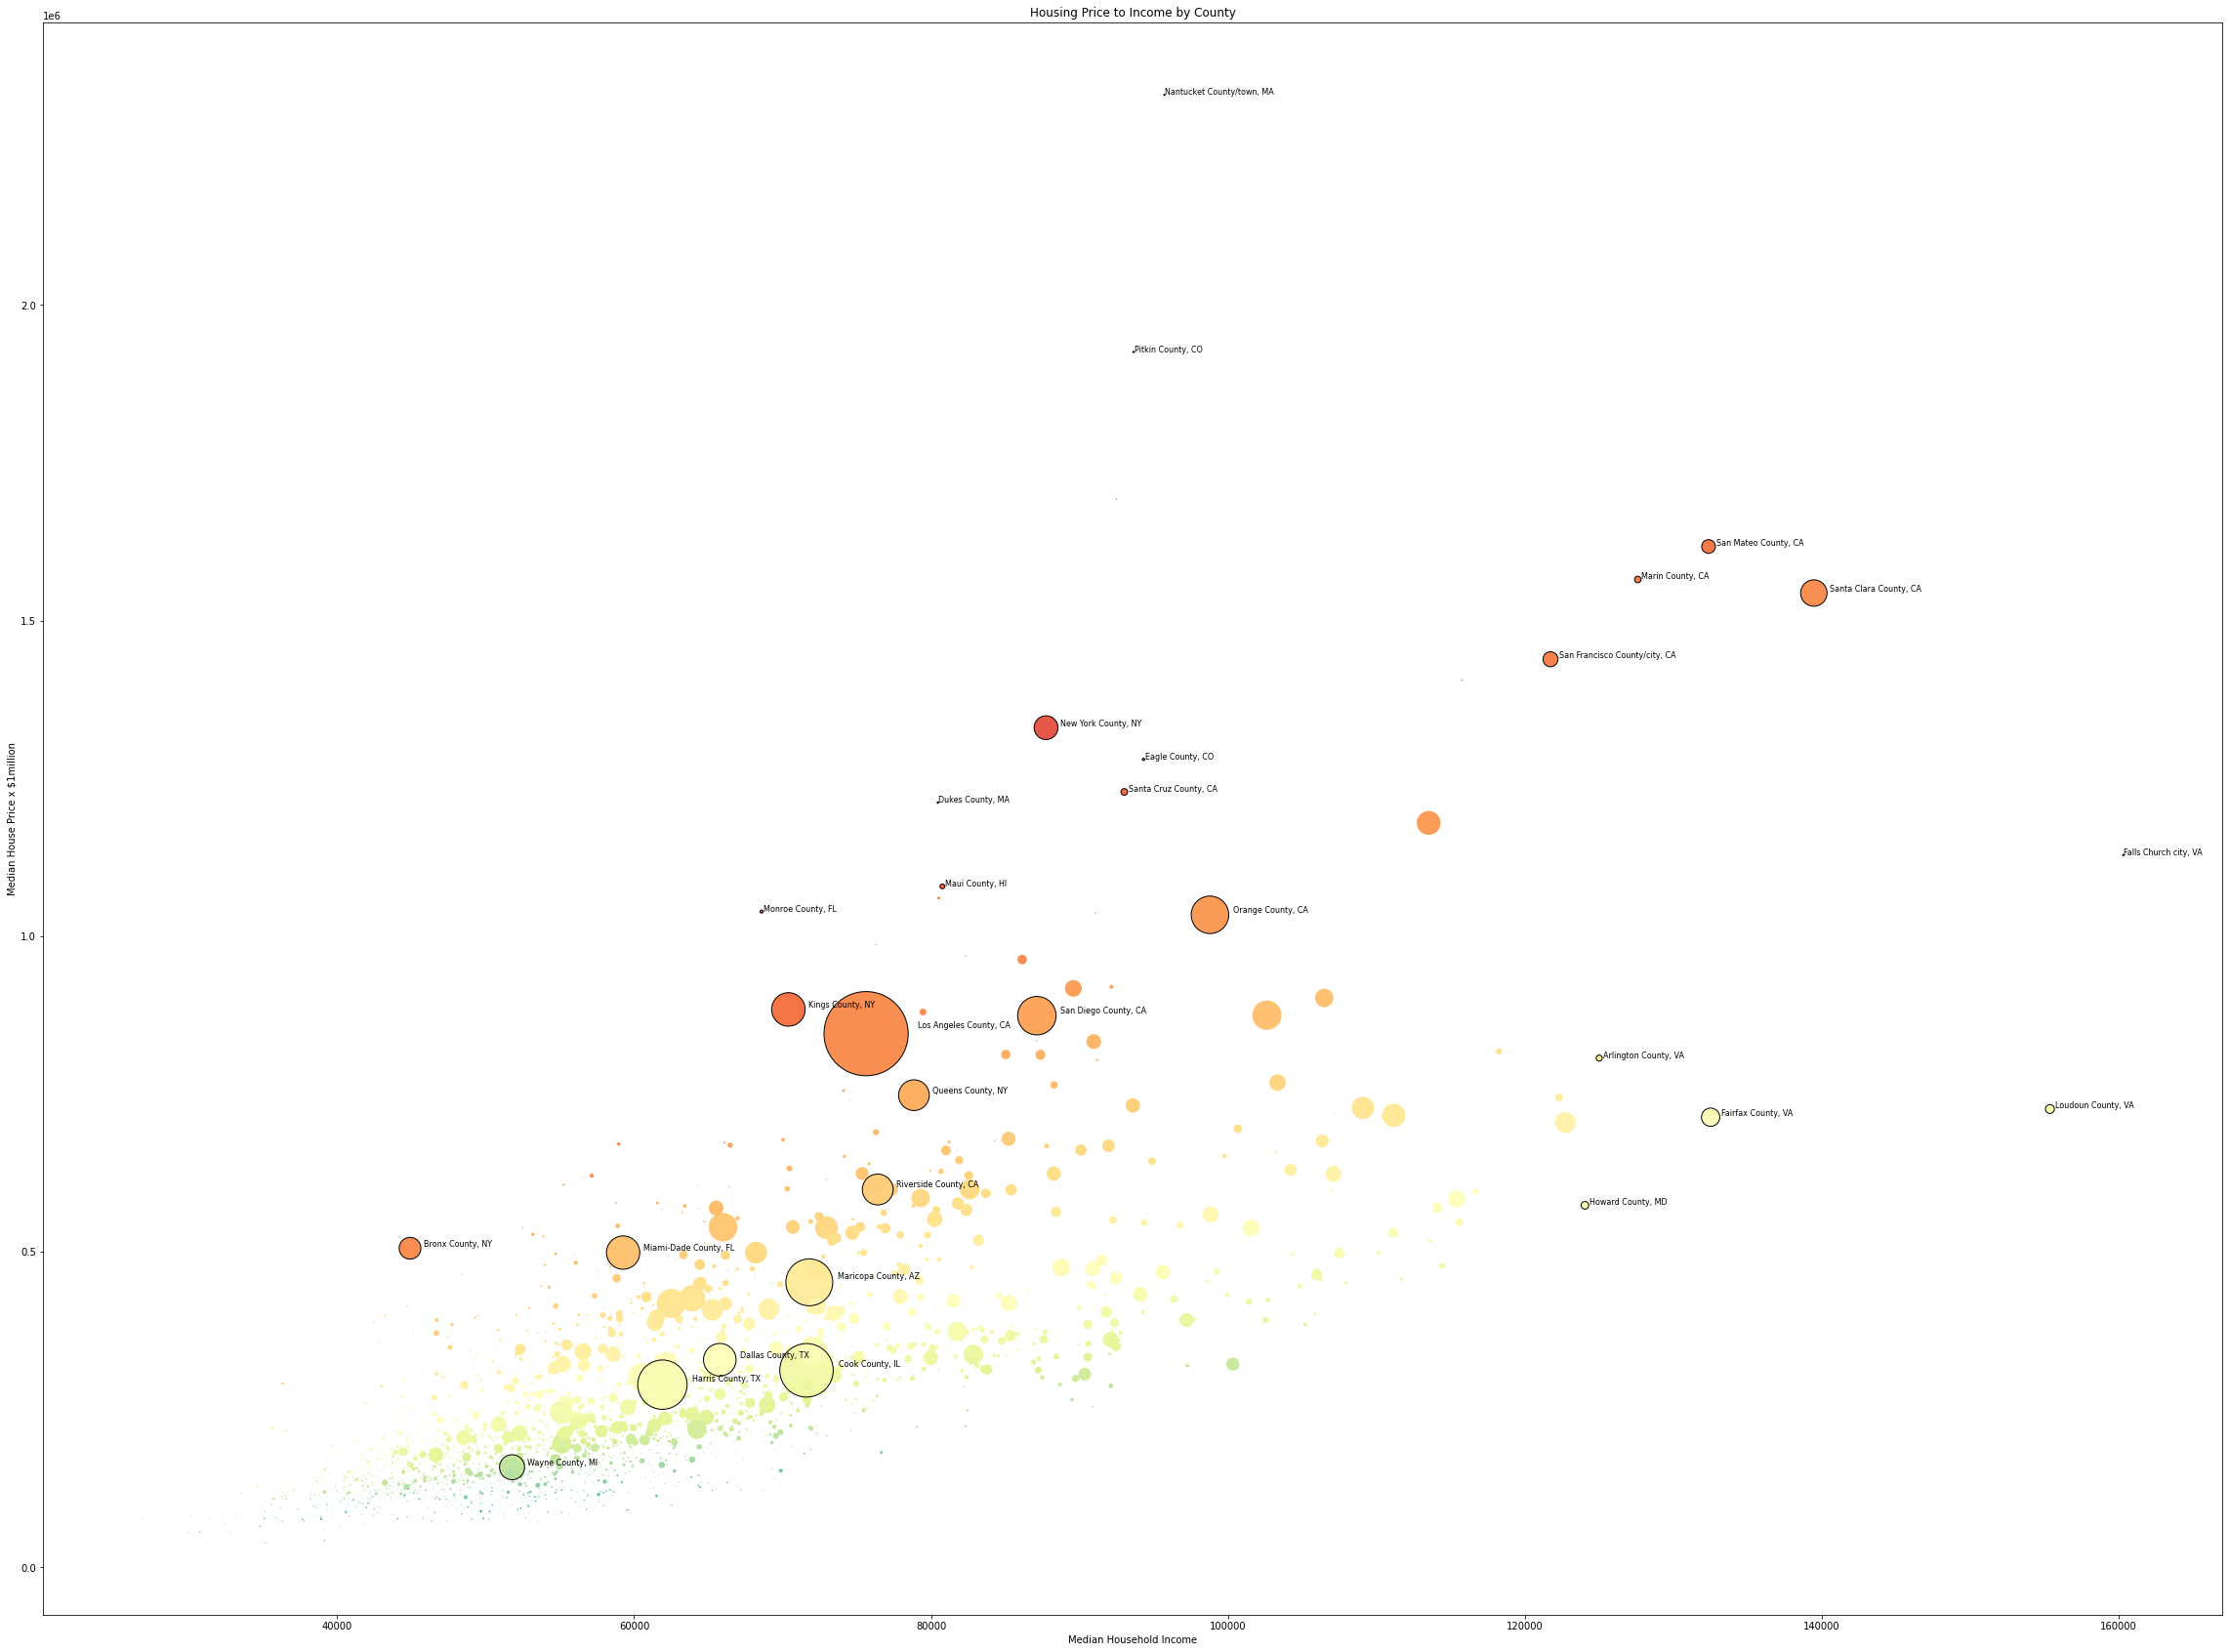

In [740]:
plot_PIR_scatter([
# Highest PIR
    'Nantucket County/town, MA',
    'Pitkin County, CO',
    'Teton County, WY'
    'San Miguel County, CO',
    'New York County, NY',
    'Monroe County, FL',
    'Dukes County, MA',
    'Eagle County, CO',
    'San Diego County, CA',
    'Maui County, HI',
    'Santa Cruz County, CA',

# Most populated
    'Los Angeles County, CA', 
    'Cook County, IL',
    'Harris County, TX',
    'Maricopa County, AZ',
    'Orange County, CA',
    'Miami-Dade County, FL',
    'Kings County, NY',
    'Dallas County, TX',
    'Riverside County, CA',
    'Queens County, NY',
    
# Most expensive
    'San Mateo County, CA',
    'Marin County, CA',
    'Santa Clara County, CA',
    'San Francisco County/city, CA',
   # 'Summit County, UT',
   # 'San Miguel County, CO'
   

# Highest Income
    'Falls Church city, VA',
    'Loudoun County, VA',
    'Fairfax County, VA',
    'Arlington County, VA',
    'Howard County, MD',

# Other 
    'Bronx County, NY',
    'Wayne County, MI'    
    ])

Generate Regression Model

In [782]:
X = merged3[["Income","Population","Tax_Percent"]]
y = merged3[["House_Price"]]

# Create the linear regression model
model = LinearRegression()

# Create dummy variables for the categorical features "Rural_urban" and "STNAME"
#X = pd.get_dummies(X, columns=["Rural_urban"])
#X = pd.get_dummies(X, columns=["STNAME"])

# Fit the model to the data
model.fit(X, y)

# Make predictions using the model
y_pred = model.predict(X)

In [781]:
# Add a constant to the predictor variables
#X = sm.add_constant(X)
# Fit the model using the OLS (ordinary least squares) method
#model = sm.OLS(y, X).fit()
# Print the summary statistics
#print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            House_Price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     1436.
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        23:59:03   Log-Likelihood:                -36891.
No. Observations:                2840   AIC:                         7.379e+04
Df Residuals:                    2836   BIC:                         7.381e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.248e+05   8609.176    -14.497      

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


The overall model has a very high F-statistic at 1436 and extremely low p-value

Income, Population, and Tax Rate all have very strong absolute t-values and corresponding very low p-values

All variables are statistically significant at even a 0.001 alpha level

R-squared value of 0.603 means 60.3% of variability in price is explained by Income, Population, and Tax Rate.

In [794]:
plt.rcParams["figure.figsize"] = (10,6)

Plot Regression Model

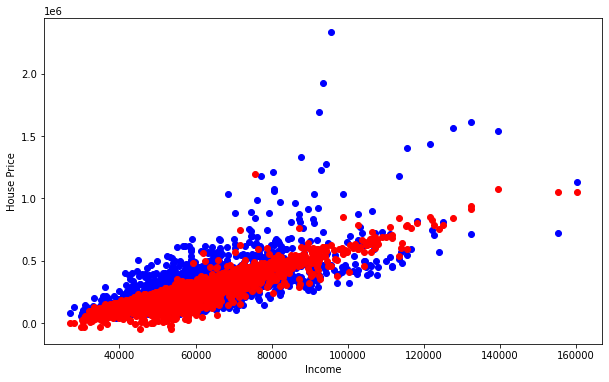

In [795]:
# Plot the data and the predictions
plt.scatter(X["Income"], y, color='b')
plt.scatter(X["Income"], y_pred, color='r')
plt.xlabel("Income")
plt.ylabel("House Price")
plt.show()


The regression line is clearly heavily impacted by a handful of very expensive outliers

Text(0, 0.5, 'Residuals')

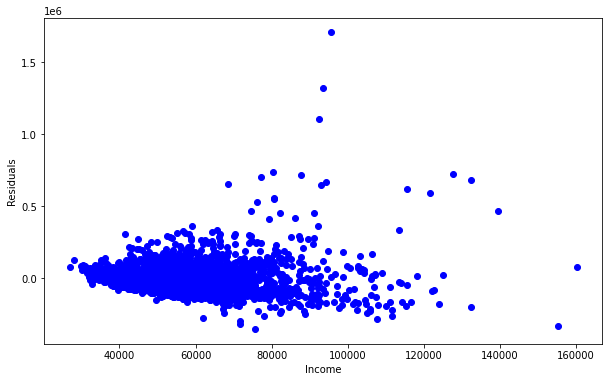

In [797]:
# Calculate the residuals
residuals = y-y_pred
# Plot the residuals
plt.scatter(X["Income"], residuals, color = 'b')
plt.xlabel("Income")
plt.ylabel("Residuals")
#plt.show()

Plot distributions

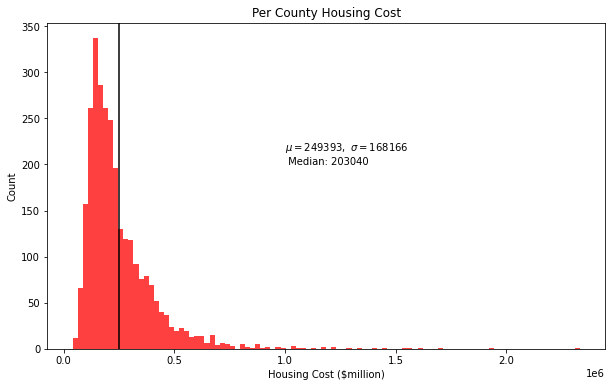

In [786]:
# Per County Housing Cost
plt.hist(merged3["House_Price"], 100, facecolor='r', alpha=.75)
plt.xlabel('Housing Cost ($million)')
plt.ylabel('Count')
plt.title('Per County Housing Cost')

plt.axvline(HP_mean, color='black')
txt = f'$\mu={HP_mean:.0f},\ \sigma={HP_SD:.0f}$\n Median: {HP_50:.0f}'
plt.text(1000000, 200, txt)

plt.savefig('House_cost.png')
plt.show()

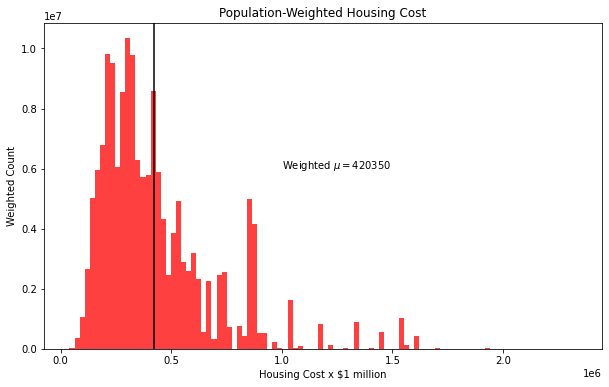

In [787]:
plt.hist(merged3["House_Price"], 100, facecolor='r', alpha=.75, weights=merged3["Labor_Force"])
plt.xlabel('Housing Cost x $1 million')
plt.ylabel('Weighted Count')
plt.title('Population-Weighted Housing Cost')

plt.axvline(HP_Wmean, color='black')
txt = f'Weighted $\mu={HP_Wmean:.0f}$'
plt.text(1000000, 6000000, txt)

plt.savefig('House_cost_weighted')
plt.show()

Plot Histogram of Price-to-Income Ratios

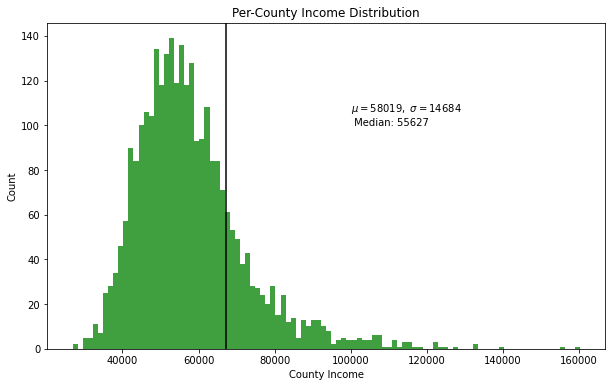

In [788]:
plt.hist(merged3["Income"], 100, facecolor='g', alpha=.75)
plt.xlabel('County Income')
plt.ylabel('Count')
plt.title('Per-County Income Distribution')
plt.axvline(US_MHI, color='black')
txt = f'$\mu={INC_mean:.0f},\ \sigma={INC_SD:.0f}$\n Median: {INC_50:.0f}'
plt.text(100000, 100, txt)
plt.savefig('Income.png')
plt.show()

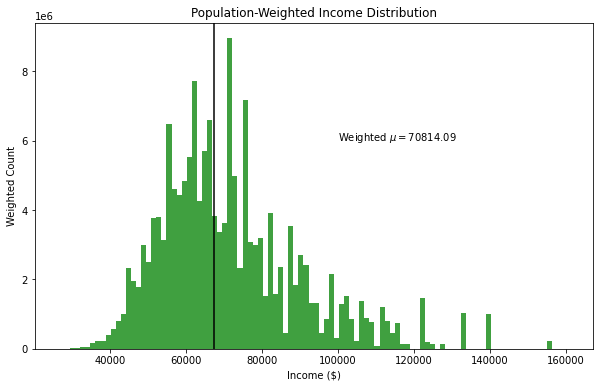

In [789]:
plt.hist(merged3["Income"], 100, facecolor='g', alpha=.75, weights=merged3["Labor_Force"])
plt.xlabel('Income ($)')
plt.ylabel('Weighted Count')
plt.title('Population-Weighted Income Distribution')
plt.axvline(US_MHI, color='black')
txt = f'Weighted $\mu={INC_Wmean:.2f}$'
plt.text(100000, 6000000, txt)
plt.savefig('Income_weighted.png')
plt.show()

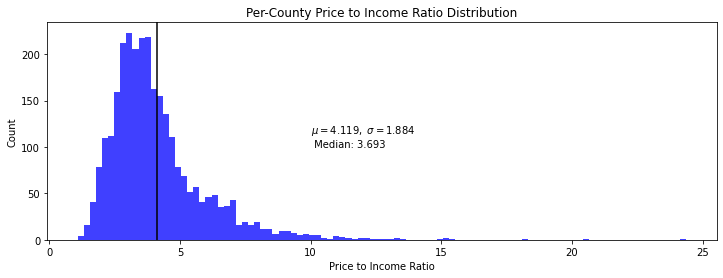

In [790]:
plt.rcParams["figure.figsize"] = (12,4)

plt.hist(merged3[PIR], 100, facecolor='b', alpha=.75)


plt.xlabel('Price to Income Ratio')
plt.ylabel('Count')
plt.title('Per-County Price to Income Ratio Distribution')
plt.axvline(PIR_mean, color='black')
#plt.axvline(PIR_50, color='black')
#plt.axvline(PIR_75, color='black')


txt = f'$\mu={PIR_mean:.3f},\ \sigma={PIR_SD:.3f}$\n Median: {PIR_50:.3f}'
plt.text(10, 100, txt)
plt.savefig('PIR.png')
plt.show()

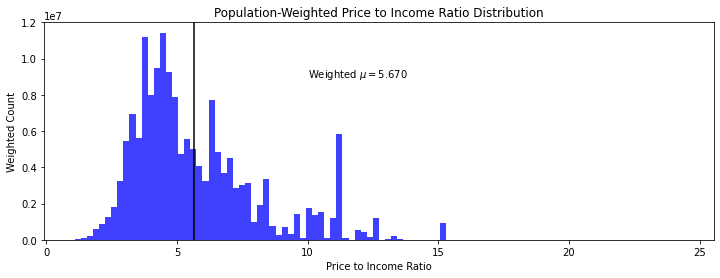

In [791]:
plt.hist(merged3[PIR], 100, facecolor='b', alpha=.75, weights=merged3["Labor_Force"])


plt.xlabel('Price to Income Ratio')
plt.ylabel('Weighted Count')
plt.title('Population-Weighted Price to Income Ratio Distribution')
plt.axvline(PIR_Wmean, color='black')
#plt.axvline(PIR_50, color='black')
#plt.axvline(PIR_75, color='black')
txt = f'Weighted $\mu={PIR_Wmean:.3f}$'
plt.text(10, 9000000, txt)
plt.savefig('PIR_weighted.png')
plt.show()

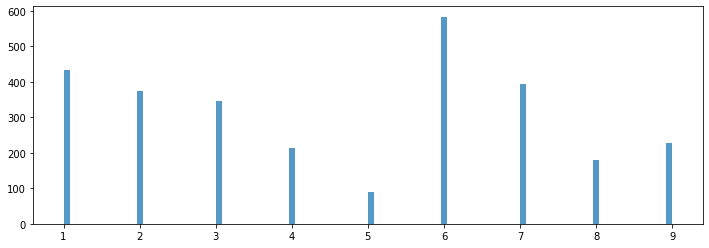

In [792]:
n, bins, patches = plt.hist(merged3["Rural_urban"], 100, alpha=.75)